Load Julia packages (libraries) needed.

In [1]:
using StatisticalRethinking, CmdStan
#gr(size=(600,600));

ProjDir = rel_path("..", "scripts", "05")
cd(ProjDir)

### snippet 5.1

In [2]:
wd = CSV.read(rel_path("..", "data", "WaffleDivorce.csv"), delim=';');
df = convert(DataFrame, wd);
df[!, :A] = scale(df[!, :MedianAgeMarriage]);
df[!, :D] = scale(df[!, :Divorce]);
first(df, 5)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce
,String,String,Float64,Float64,Float64,Float64,Float64
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8
4,Arkansas,AR,2.92,24.3,26.4,1.7,13.5
5,California,CA,37.25,26.8,19.1,0.39,8.0


### snippet 5.1

In [3]:
std(df[!, :MedianAgeMarriage])

ad = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] D; // Outcome
 vector[N] A; // Predictor
}

parameters {
 real a; // Intercept
 real bA; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
  vector[N] mu;
  a ~ normal(0, 0.2);
  bA ~ normal(0, 0.5);
  sigma ~ exponential(1);
  mu = a + bA * A;
  D ~ normal(mu , sigma);
}
";

Define the Stanmodel and set the output format to :mcmcchains.

In [4]:
m5_1s = Stanmodel(name="MedianAgeDivorce", model=ad);


File /Users/rob/.julia/dev/StatisticalRethinking/scripts/05/tmp/MedianAgeDivorce.stan will be updated.



Input data for cmdstan

In [5]:
data = Dict("N" => length(df[!, :D]), "D" => df[!, :Divorce],
    "A" => df[!, :A]);

Sample using cmdstan

In [6]:
rc, chn, cnames = stan(m5_1s, data, ProjDir, diagnostics=false,
  summary=true, CmdStanDir=CMDSTAN_HOME);

Inference for Stan model: MedianAgeDivorce_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.044, 0.043, 0.043, 0.044) seconds, 0.17 seconds total
Sampling took (0.058, 0.066, 0.060, 0.065) seconds, 0.25 seconds total

                 Mean     MCSE  StdDev     5%    50%   95%    N_Eff  N_Eff/s    R_hat
lp__             -147  2.7e-02     1.3   -150   -147  -146  2.1e+03  8.4e+03  1.0e+00
accept_stat__    0.91  7.0e-03    0.10   0.70   0.95   1.0  2.2e+02  8.9e+02  1.0e+00
stepsize__       0.76  4.3e-02   0.062   0.68   0.79  0.85  2.0e+00  8.1e+00  2.5e+13
treedepth__       2.2  9.1e-02    0.54    1.0    2.0   3.0  3.6e+01  1.4e+02  1.0e+00
n_leapfrog__      4.7  2.7e-01     2.0    3.0    3.0   7.0  5.6e+01  2.3e+02  1.0e+00
divergent__      0.00      nan    0.00   0.00   0.00  0.00      nan      nan      nan
energy__          149  4.2e-02     1.8    147    149   152  1.8e+03  7.0e+03  1.0e+00
a               

Describe the draws

In [7]:
MCMCChains.describe(chn)

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean      │ std      │ naive_se   │ mcse      │ ess     │
│     │ Symbol     │ Float64   │ Float64  │ Float64    │ Float64   │ Any     │
├─────┼────────────┼───────────┼──────────┼────────────┼───────────┼─────────┤
│ 1   │ a          │ 0.228389  │ 0.205793 │ 0.00325388 │ 0.0026611 │ 3777.44 │
│ 2   │ bA         │ -0.141719 │ 0.469129 │ 0.00741758 │ 0.0067692 │ 3724.72 │
│ 3   │ sigma      │ 9.01439   │ 0.833701 │ 0.013182   │ 0.0114175 │ 3917.96 │

Quantiles

│ Row │ parameters │ 2.5%      │ 25.0%     │ 50.0%     │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64   │ Float64   │ Float64   │ Float64  │ Float64  │
├─────┼────────────┼───────────┼───────────┼───────────┼──────────┼──────────┤
│ 1   │ a          │ -0.179397 │ 0.0903684 │ 0.23076   │ 0.36533  │ 0.624633 │
│ 2   │ bA         │ -1.06137  │ -0.462788 │ -0.142668 │ 0.186221 │ 0.755953 │
│ 3   │ sigma      │ 7.59709   │ 

Plot the density of posterior draws

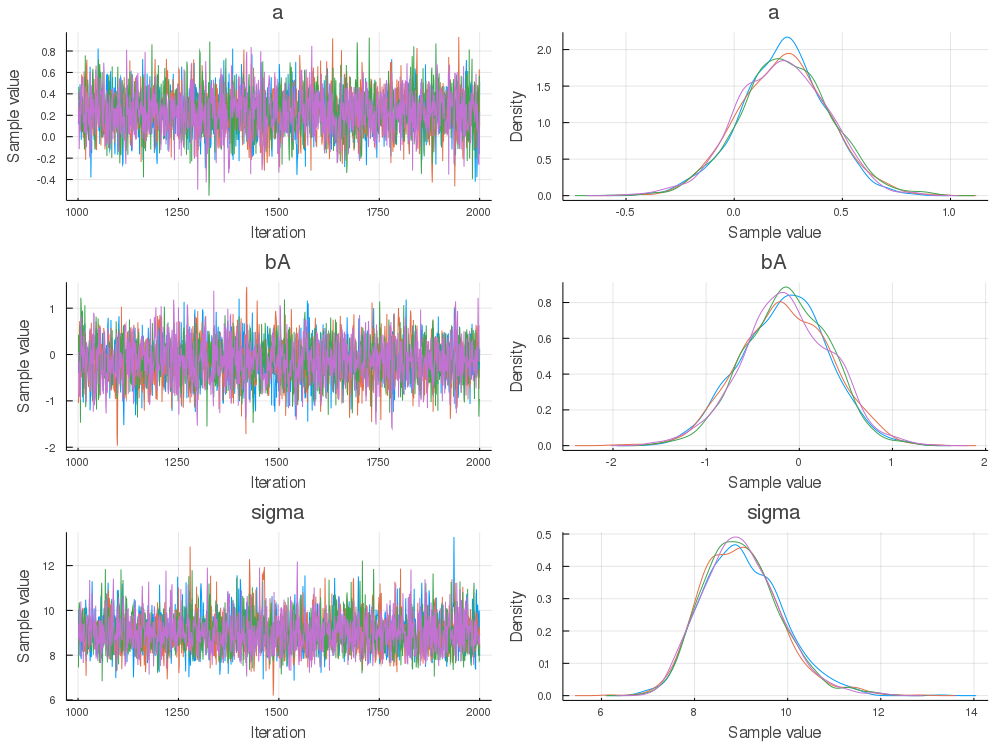

In [8]:
plot(chn)

Result rethinking

In [9]:
rethinking = "
       mean   sd  5.5% 94.5% n_eff Rhat
a      9.69 0.22  9.34 10.03  2023    1
bA    -1.04 0.21 -1.37 -0.71  1882    1
sigma  1.51 0.16  1.29  1.79  1695    1
"

"\n       mean   sd  5.5% 94.5% n_eff Rhat\na      9.69 0.22  9.34 10.03  2023    1\nbA    -1.04 0.21 -1.37 -0.71  1882    1\nsigma  1.51 0.16  1.29  1.79  1695    1\n"

Plot regression line using means and observations

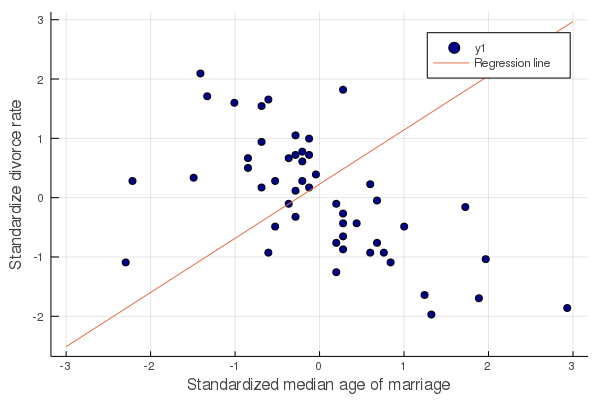

In [10]:
xi = -3.0:0.01:3.0
rws, vars, chns = size(chn)
alpha_vals = convert(Vector{Float64}, reshape(chn.value[:, 1, :], (rws*chns)))
beta_vals = convert(Vector{Float64}, reshape(chn.value[:, 2, :], (rws*chns)))
yi = mean(alpha_vals) .+ mean(beta_vals)*xi

scatter(df[!, :A], df[!, :D], color=:darkblue,
  xlab="Standardized median age of marriage",
  ylab="Standardize divorce rate")
plot!(xi, yi, lab="Regression line")

shade(), abline() and link()

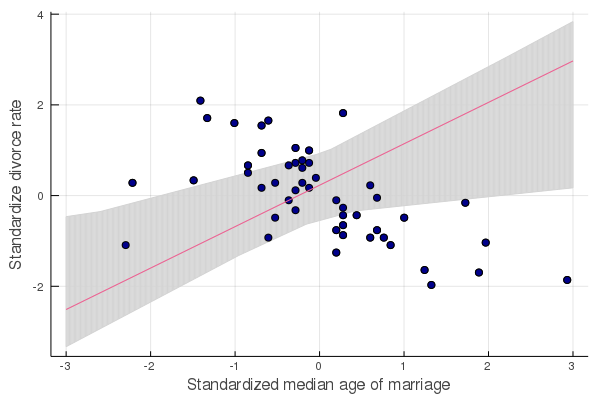

In [11]:
mu = link(xi, chn, [1, 2], mean(xi));
yl = [minimum(mu[i]) for i in 1:length(xi)];
yh =  [maximum(mu[i]) for i in 1:length(xi)];
ym =  [mean(mu[i]) for i in 1:length(xi)];
pi = hcat(xi, yl, ym, yh);
pi[1:5,:]

plot!((xi, yl), color=:lightgrey, leg=false)
plot!((xi, yh), color=:lightgrey, leg=false)
for i in 1:length(xi)
  plot!([xi[i], xi[i]], [yl[i], yh[i]], color=:lightgrey, leg=false)
end
scatter!(df[!, :A], df[!, :D], color=:darkblue)
plot!(xi, yi, lab="Regression line")

End of `05/m5.1s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*